In [12]:
# Data Processing & Modeling Libraries
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
import statsmodels.formula.api as smf
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

# Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno


In [2]:
# Import Data
df = pd.read_csv('bank_data.csv', header = 'infer')
df.head()



,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


c:\Users\andyh\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
c:\Users\andyh\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\matrix.py:309: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


<Axes: >

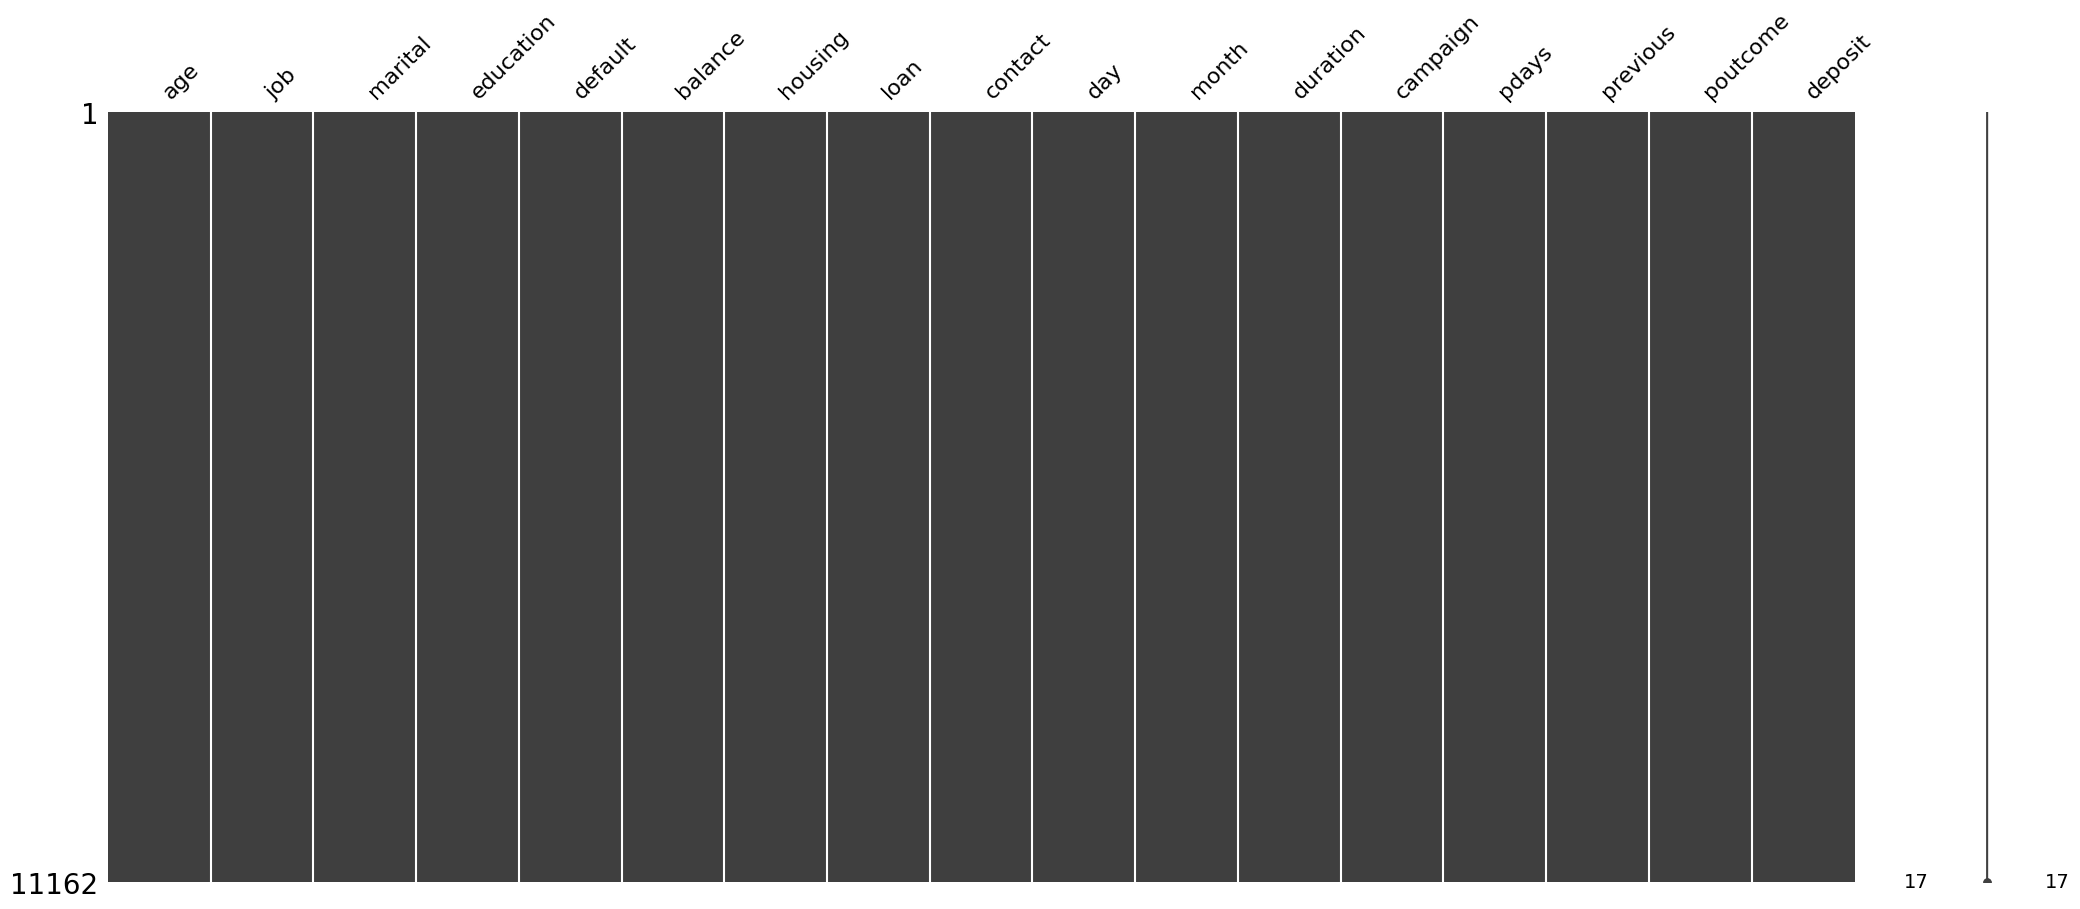

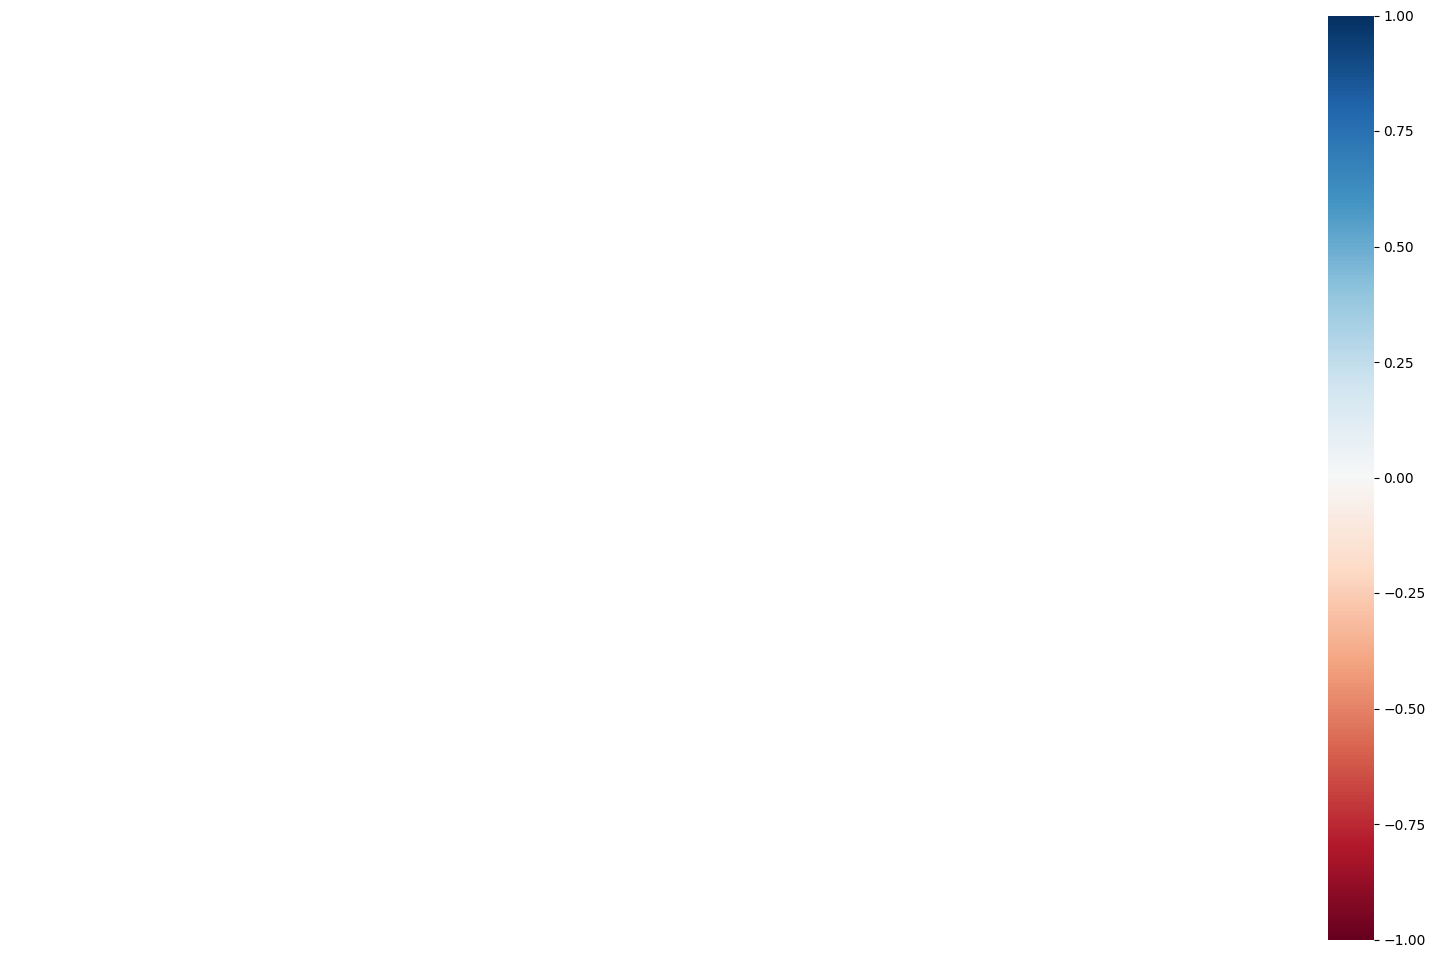

In [3]:
# Explore and Validate Data
df.info()
df.head()

# Missing Values & Imputation if Needed 
msno.matrix(df)
msno.heatmap(df)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB
Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'pou

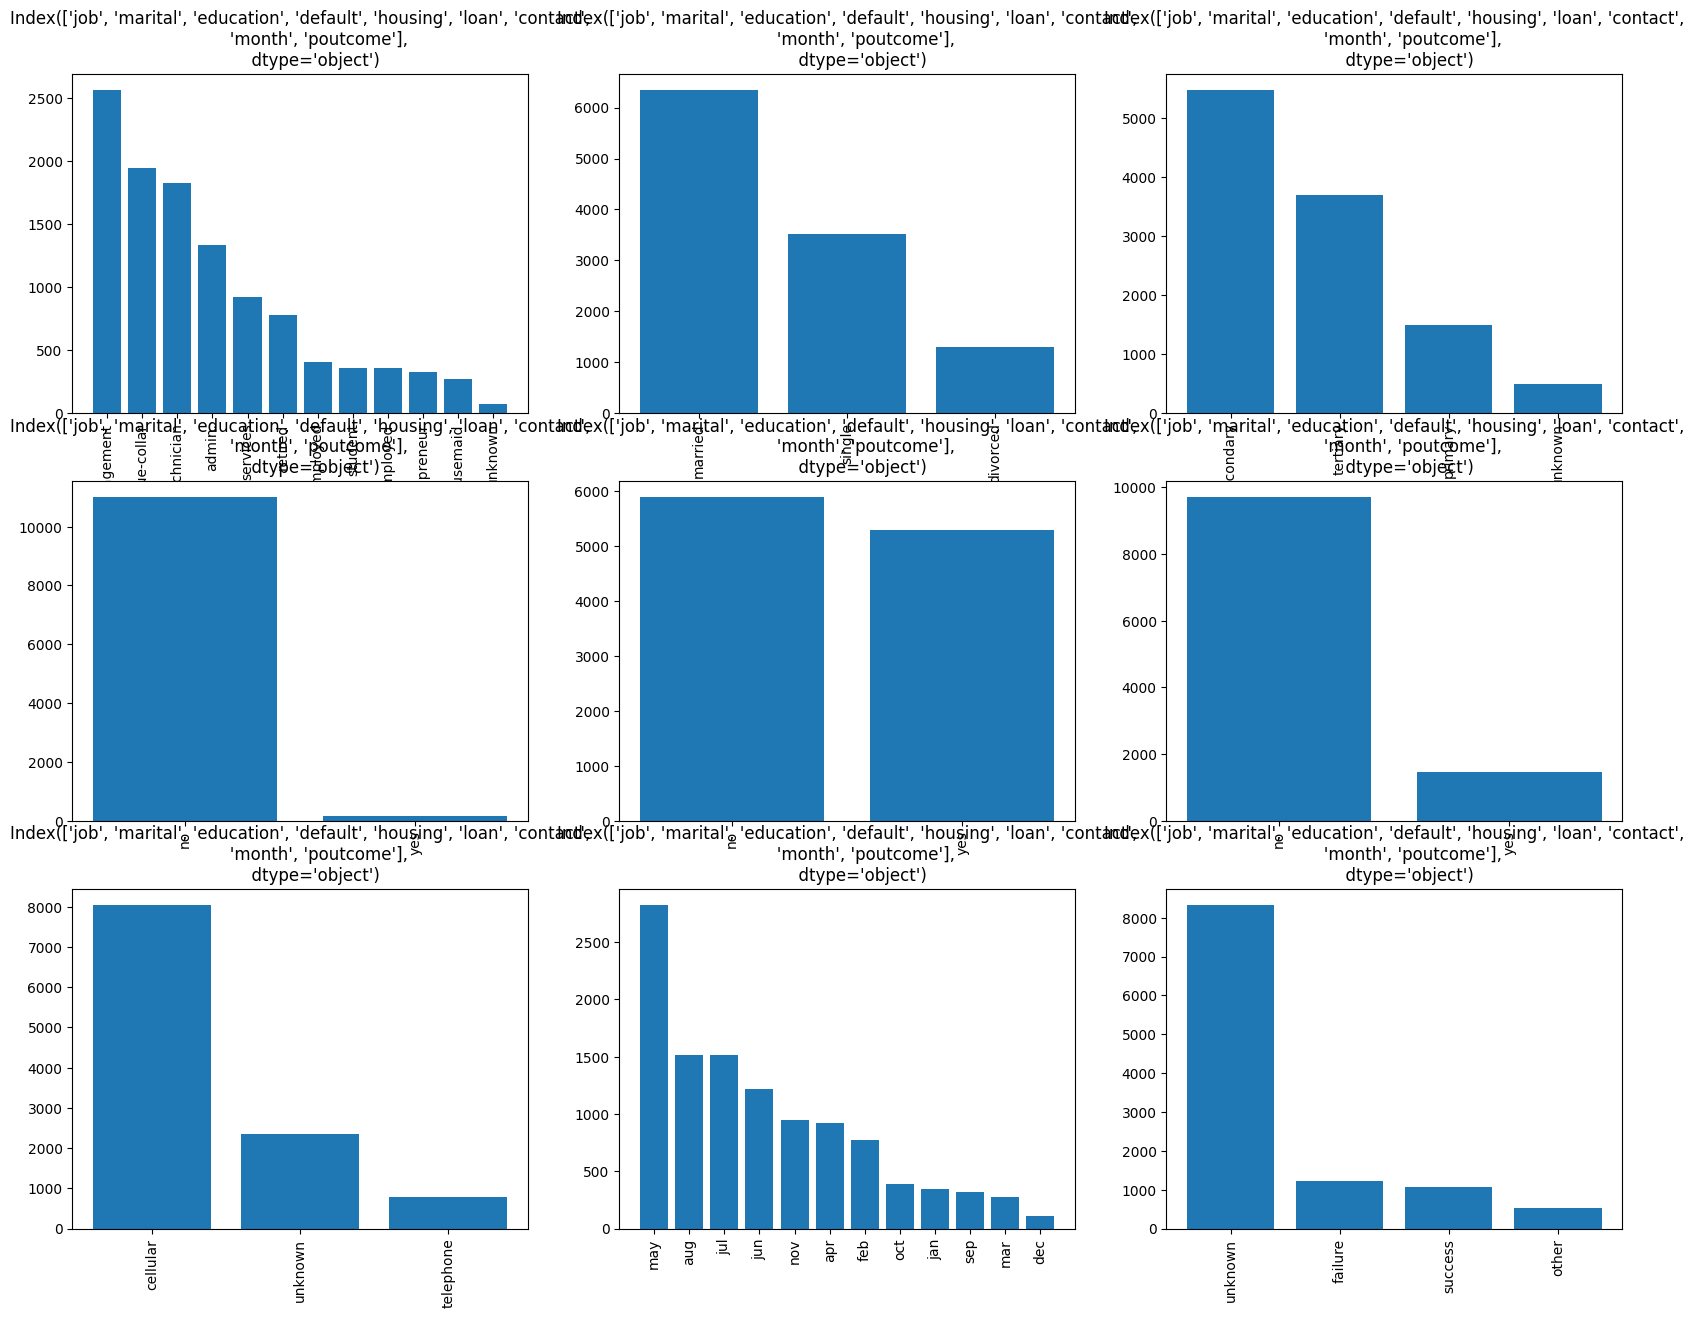

In [4]:
# Inspect Categorical Columns 
df.info()
cat_cols = df.select_dtypes(include = ['object']).columns
cat_cols = cat_cols[~cat_cols.isin(['deposit'])]

print(cat_cols)

# Visualize cat_cols for eda

figs, axs = plt.subplots(3, 3, sharex= False, sharey = False, figsize = (20, 15))

counter = 0
for cat_col in cat_cols:
    value_counts = df[cat_col].value_counts()
    
    trace_x = counter // 3
    trace_y = counter % 3
    x_pos = np.arange(0, len(value_counts))
    
    axs[trace_x, trace_y].bar(x_pos, value_counts.values, tick_label = value_counts.index)
    
    axs[trace_x, trace_y].set_title(cat_cols)
    
    for tick in axs[trace_x, trace_y].get_xticklabels():
        tick.set_rotation(90)
    
    counter += 1

plt.show()



Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'], dtype='object')


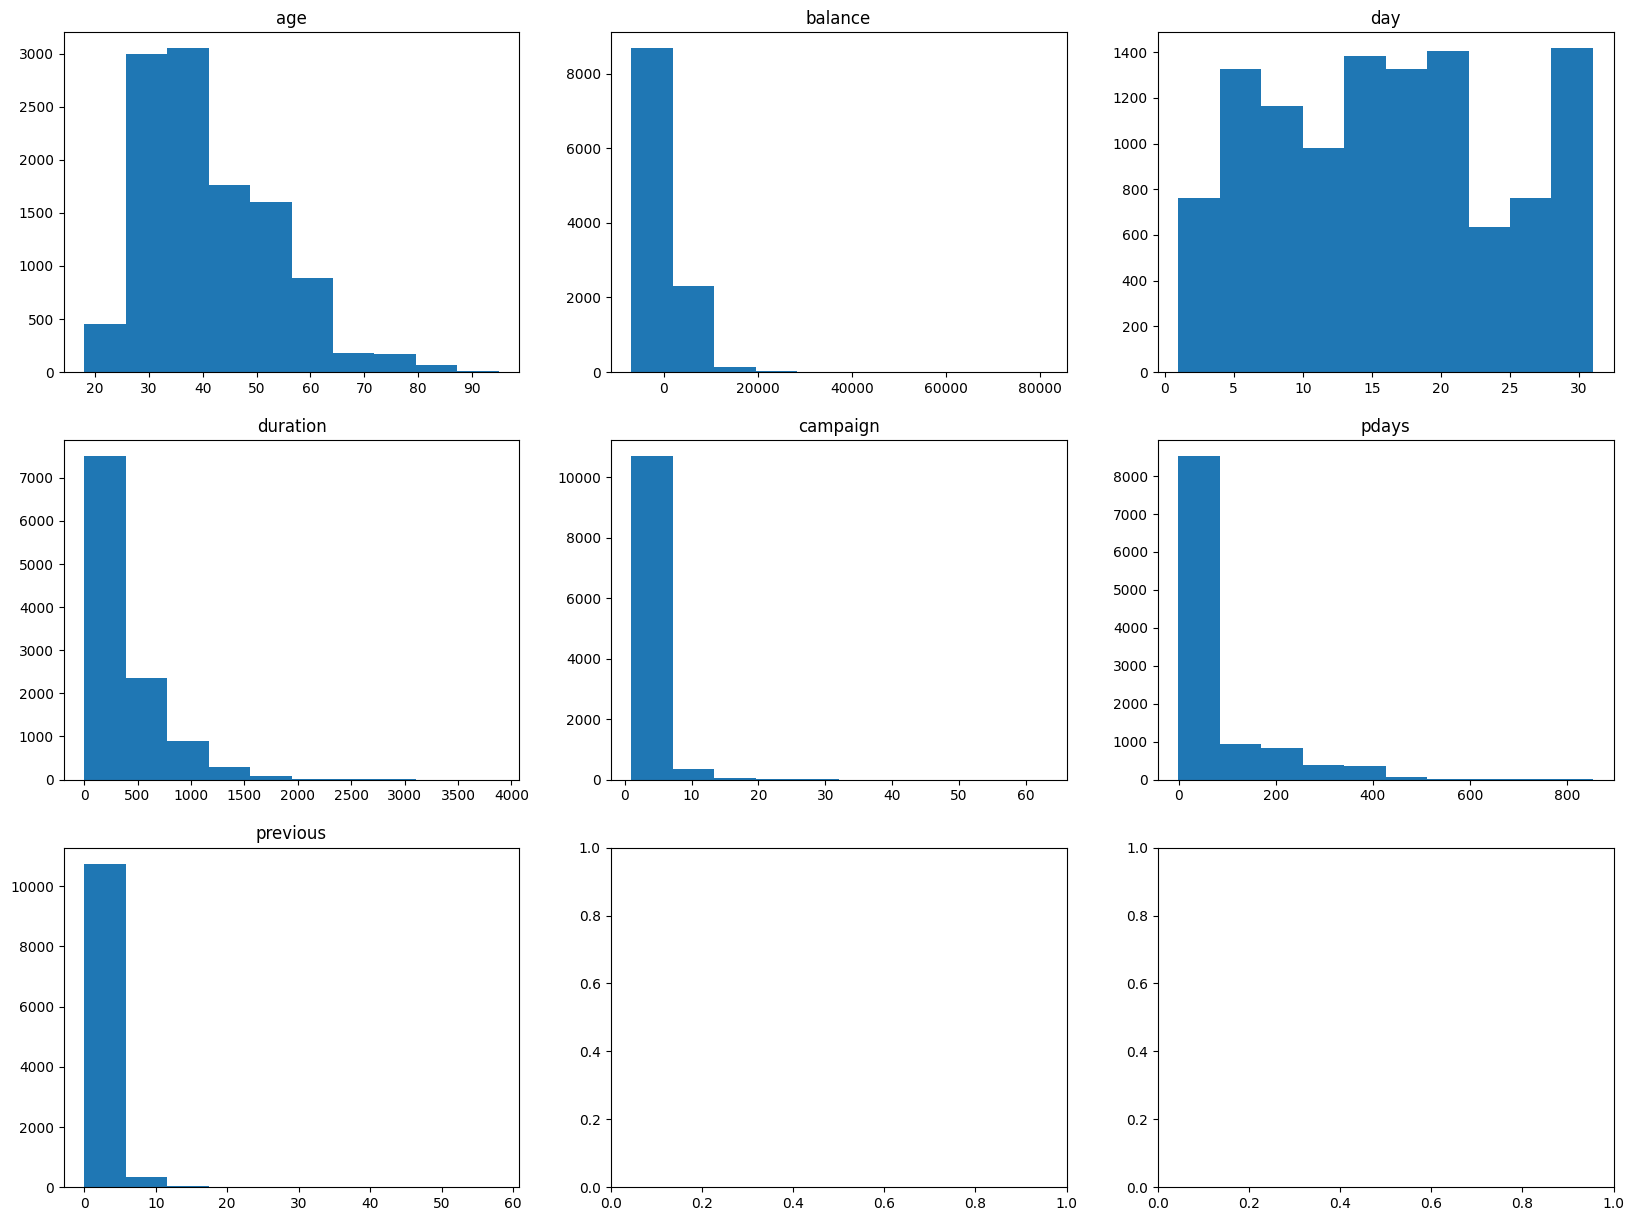

In [5]:
# Numerical Columns Exploration
num_cols = df.select_dtypes(include = 'int64').columns
print(num_cols)

fig, axs = plt.subplots(3, 3, sharex=False, sharey=False, figsize=(20, 15))

counter = 0
for num_col in num_cols:
    
    trace_x = counter // 3
    trace_y = counter % 3
    
    axs[trace_x, trace_y].hist(df[num_col])
    
    axs[trace_x, trace_y].set_title(num_col)
    
    counter += 1

plt.show()

In [6]:
# Inspecting Histogram Above, [pdays, campaign, duration, balance, previous] may have outliers... inspect
outlier_cols = ['pdays', 'campaign', 'previous', 'balance', 'duration']
print(df[outlier_cols].describe())

# Look in to pdays, pdays -> is the number of days passed by after contacting with last campaign.

# pdays, negative values make up 75% of the dataset, since its impossible to have negative values, drop column if no validation method
fraction_negative = len(df[df['pdays'] < 0])/ len(df['pdays'])
# -1 in pdays may represent client has never been contacted before. Thus create a boolean column for -1, and not negative, validate it against campaign
df['pdays_bool'] = df['pdays'] >= 0

# create campaign boolean
df['campaign_bool'] = df['campaign'] >= 0

# compare the two columns
df['match'] = df['pdays_bool'] == df['campaign_bool']
exact_matches = df['match'].sum()
total_rows = len(df)

match_fraction = exact_matches/total_rows
match_fraction

# match_fraction does not show overlap in data. Therefore, we can drop pdays. 


# Next inpsect Days, Since campaign was run for 30 days check observations above 30
print(len(df[df['day'] > 30])/len(df))

# since values above 30 makes up 1.3% of dataset, just impute with average
average = df[df['day'] <= 30]['day'].mean()
df.loc[df['day'] > 30, 'day'] = average



              pdays      campaign      previous       balance      duration
count  11162.000000  11162.000000  11162.000000  11162.000000  11162.000000
mean      51.330407      2.508421      0.832557   1528.538524    371.993818
std      108.758282      2.722077      2.292007   3225.413326    347.128386
min       -1.000000      1.000000      0.000000  -6847.000000      2.000000
25%       -1.000000      1.000000      0.000000    122.000000    138.000000
50%       -1.000000      2.000000      0.000000    550.000000    255.000000
75%       20.750000      3.000000      1.000000   1708.000000    496.000000
max      854.000000     63.000000     58.000000  81204.000000   3881.000000
0.01254255509765275


C:\Users\andyh\AppData\Local\Temp\ipykernel_32936\4058670425.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '15.463164579931046' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df['day'] > 30, 'day'] = average


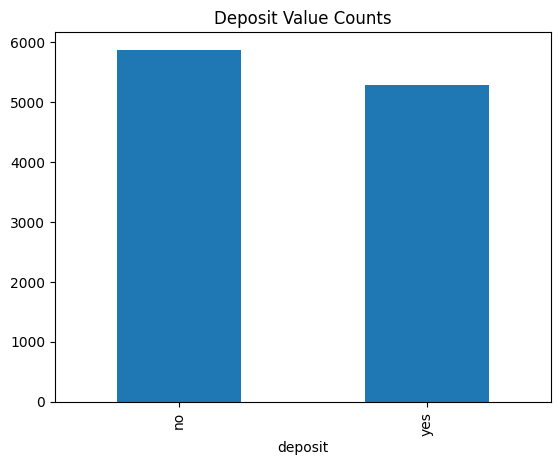

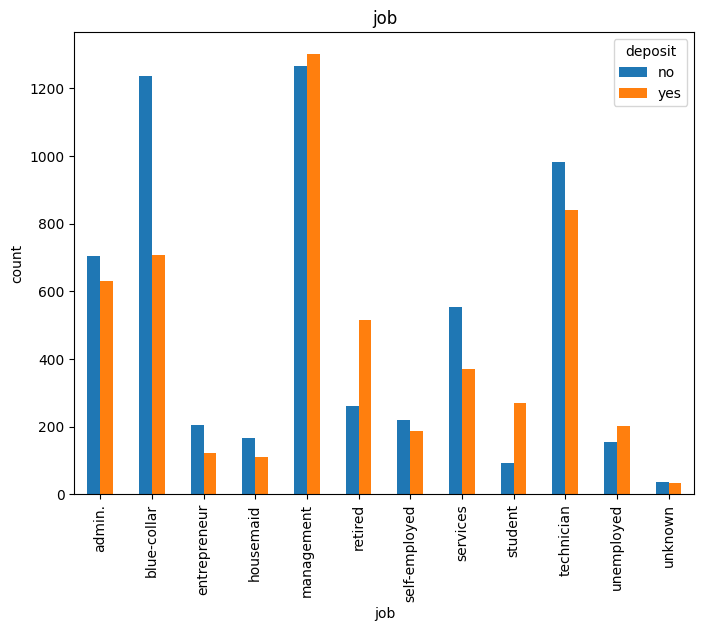

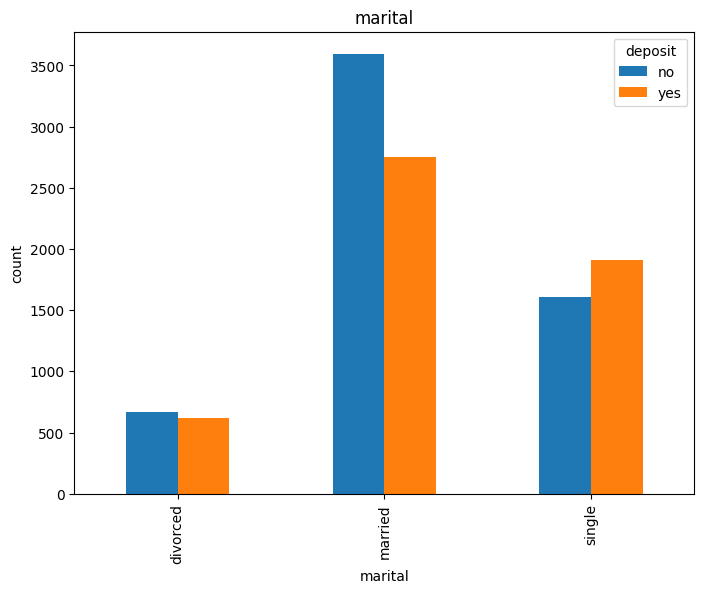

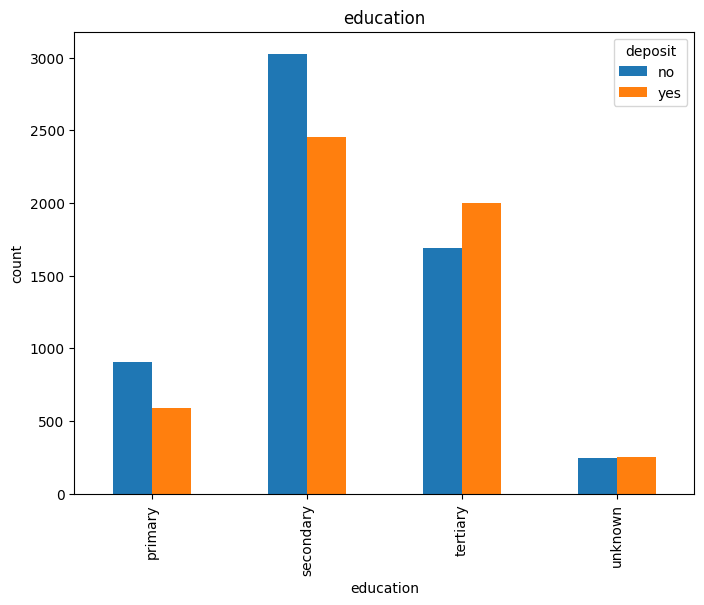

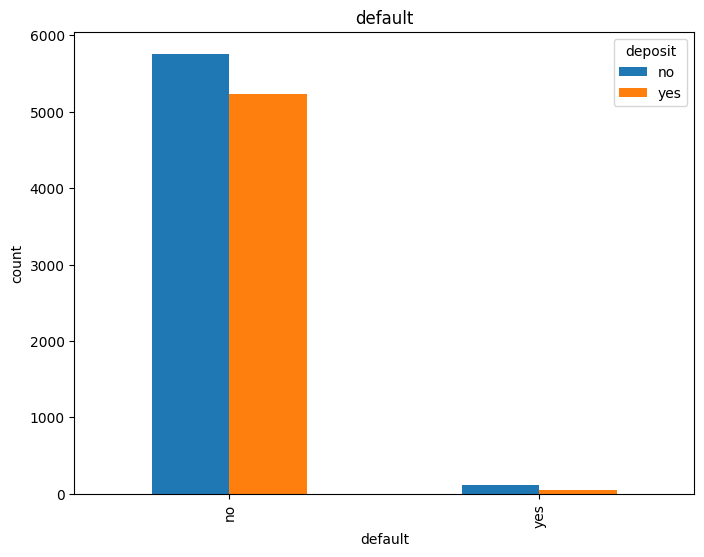

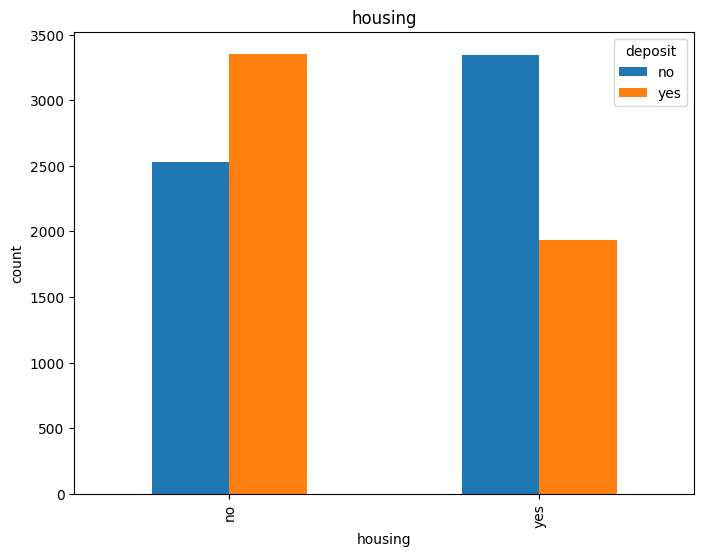

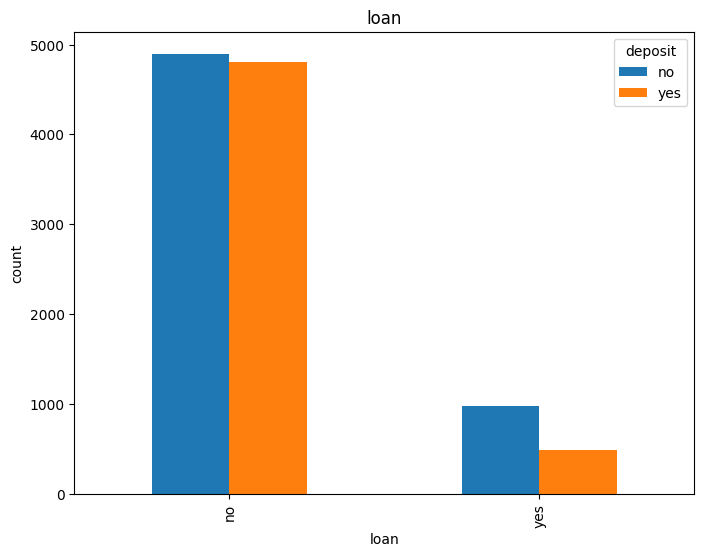

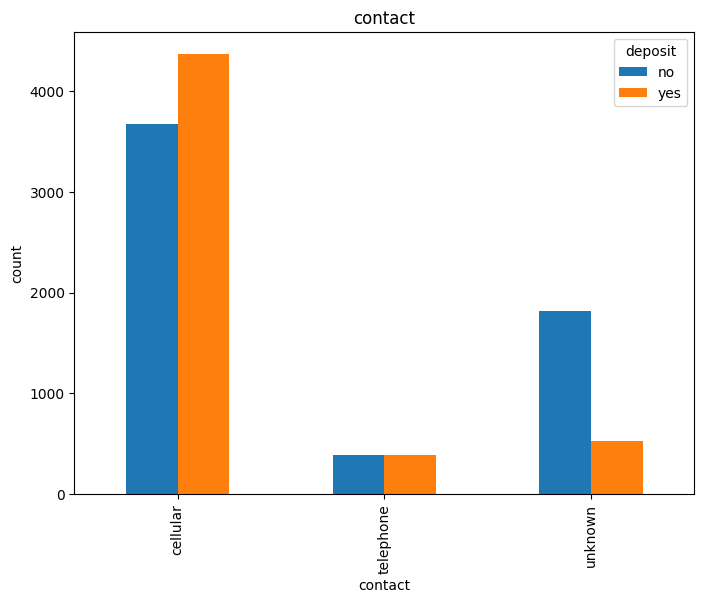

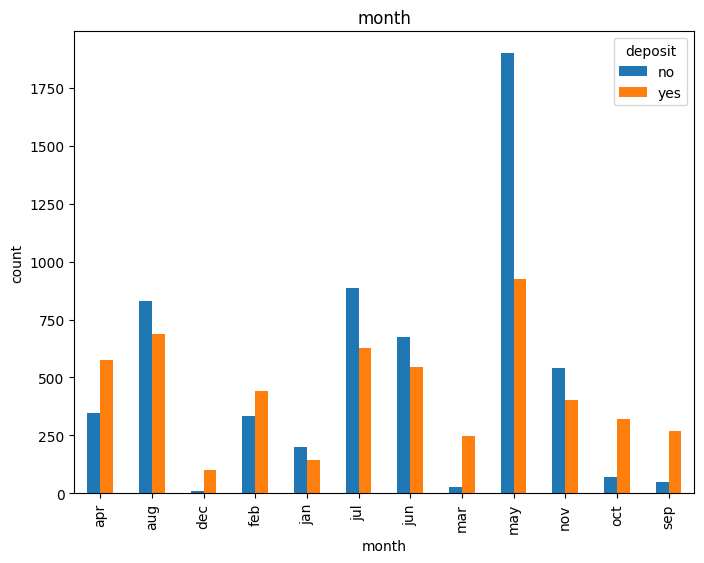

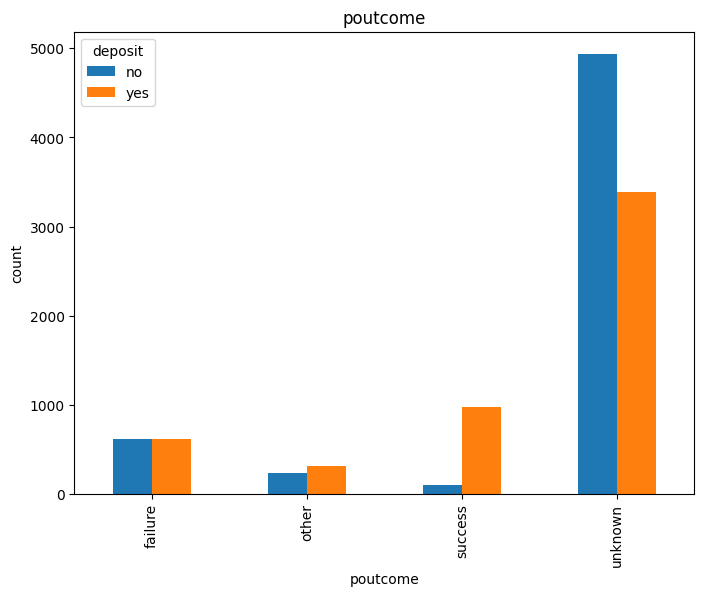

In [7]:
# Inspect Dependent Variable 'deposit'
value_counts = df['deposit'].value_counts()
value_counts.plot.bar(title = 'Deposit Value Counts')

# Inspect the deposit split in independent variables 

## categorical variables 

for cat_col in cat_cols:
    grouped_data = df.groupby([cat_col, 'deposit']).size().unstack(fill_value=0)

    grouped_data.plot(kind= 'bar', figsize = (8, 6), stacked= False)

    plt.title(f'{cat_col}')
    plt.ylabel('count')
    plt.legend(title = 'deposit') 

    plt.show()



# Blue-Collar & Service jobs -> least likely to subscribe for a term deposit
# married -> less likely to subscribe for term deposit
# cellular -> less likely to subscribe for term deposit 


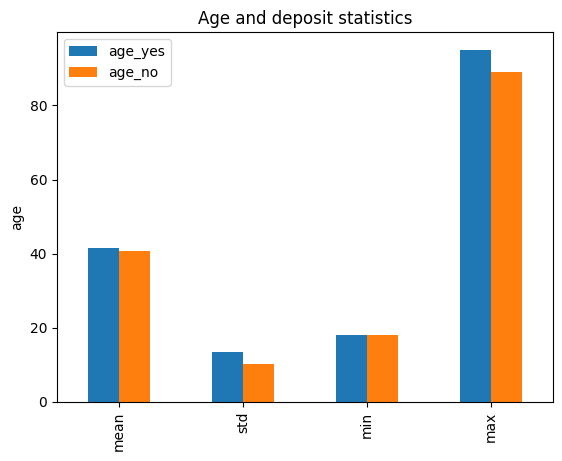

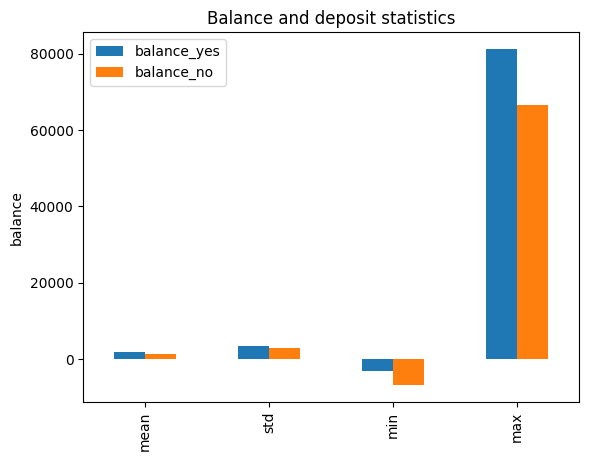

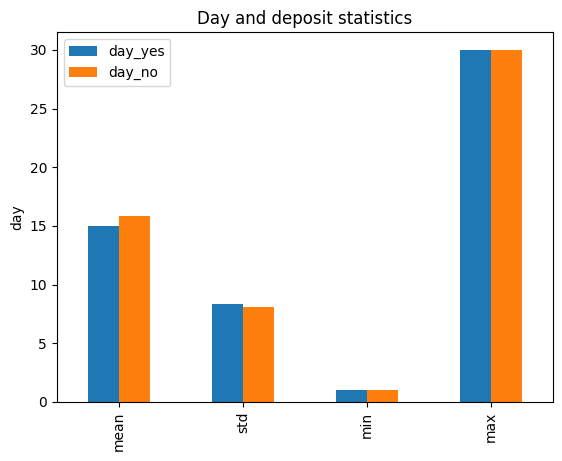

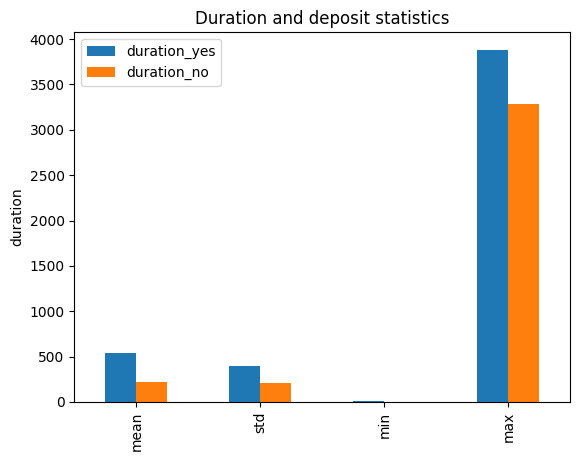

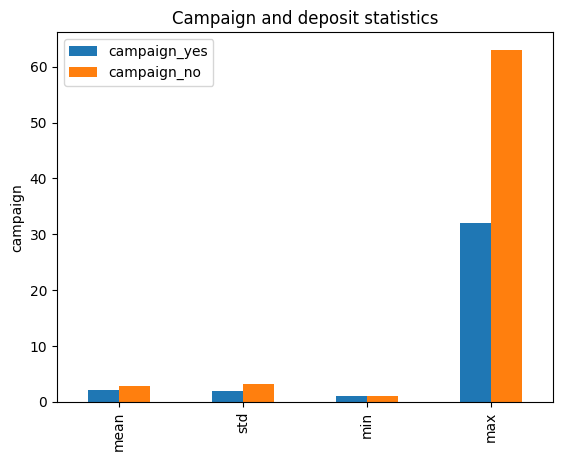

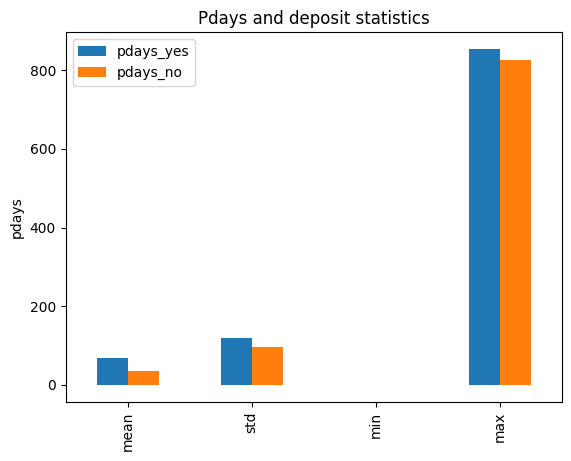

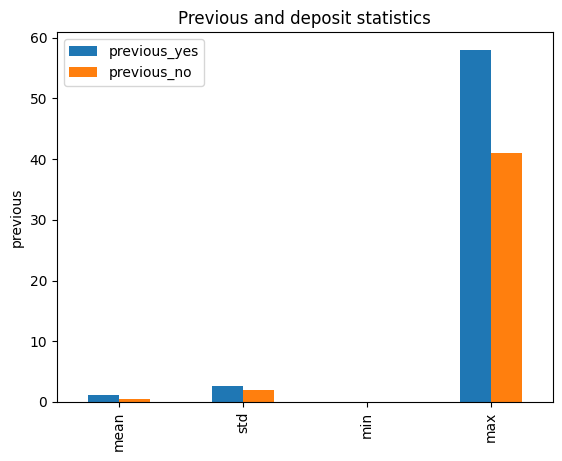

In [8]:
## numeric variables
for num_col in num_cols:
    summary_stats = pd.DataFrame()

    summary_stats[f'{num_col}_yes'] = df[df['deposit'] == 'yes'][[num_col]].describe()[num_col]
    summary_stats[f'{num_col}_no'] = df[df['deposit'] == 'no'][[num_col]].describe()[num_col]

    summary_stats.drop(['count', '25%', '50%', '75%']).plot.bar(title =f'{num_col.capitalize()} and deposit statistics')

    plt.ylabel(f'{num_col}')
    plt.show()

# age -> positive correlation with age and term deposit
# balance -> positive correlation with balance and term deposit
# contacts -> negative correlation with number of days they've been contacted ago during this campaign

In [9]:
# Data Cleaning

# get model columns 
col_names = ['age', 'job', 'marital', 'education', 'default' ,'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'previous', 'poutcome', 'deposit']

df_model = df[col_names]

# Change bool cols to right type, ['default', 'housing', 'loan', 'deposit']
bool_cols = ['default', 'housing', 'loan', 'deposit']
for col in bool_cols:
    df_model[col] = df_model[col].map({'yes': 1, 'no': 0}).astype(bool)

# Convert Categorical Cols to Dummys, ['job', 'marital', 'education', 'contact', 'month', 'poutcome']
to_dummy = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']

df_model = pd.get_dummies(data = df_model, prefix = to_dummy, columns = to_dummy)

df_model = df_model.drop(columns = ['campaign', 'previous'])

C:\Users\andyh\AppData\Local\Temp\ipykernel_32936\3452508287.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model[col] = df_model[col].map({'yes': 1, 'no': 0}).astype(bool)
C:\Users\andyh\AppData\Local\Temp\ipykernel_32936\3452508287.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model[col] = df_model[col].map({'yes': 1, 'no': 0}).astype(bool)
C:\Users\andyh\AppData\Local\Temp\ipykernel_32936\3452508287.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

In [10]:
# Split model in to feature & target

df_features = df_model.drop(columns =['deposit'])
df_target = df_model[['deposit']]

test_size = 0.3

# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(df_features, df_target, test_size = test_size)

In [13]:
#Build the model
#train XGBoost model
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
xgb_model.fit(X_train,y_train.squeeze().values)

#calculate and print scores for the model for top 15 features
y_train_preds = xgb_model.predict(X_train)
y_test_preds = xgb_model.predict(X_test)

print('XGB accuracy score for train: %.3f: test: %.3f' % (
        accuracy_score(y_train, y_train_preds),
        accuracy_score(y_test, y_test_preds)))


XGB accuracy score for train: 0.909: test: 0.868


Notes on XGBClassifier 

n_estimators -> number of trees the model will build. more trees more accurate, but dim return
learning_rate(eta) -> step size shrinkage used in updating weights after each tree to prevent overfitting. It controls how much additional tree contributes to the overall model. 
gamma (min_split_loss) -> min loss reduction required to make a split at the leaf node. 
subsample -> fraction of the training data to be used for growing each tree. (elaborate)
colsample_bytree -> fraction of features to be randomly sampled for each tree
max_depth -> maximum depth of each tree

Determining & Tuning Params
1. Bias-Variane Tradeoff -> max_depth, n_estimators, learning_rate directly affect this
- high bias -> model too simple, 
- high variance -> over fit

Strategies for Tuning
1. start with XGB's baseline parameters
2. use cross-validation -> implement k-fold cross-validation to eval how changes in parameters affect model

3. Sequential Parameter Turning
a. max depth & min_child_weight
    - control overfitting by adjusting tree complexity
    - use grid search over range of values

b. gamma
    - adjust to prevent overfitting and improve generalization
    - try values like 0, 0.1, 0.2 ...

c. subsample & colsample_bytree
    - adjust to prevent overfitting and improve generalization
    - try values between 0.5 & 1.0

d. regularlization params
    - lambda, alpha, add l1 & l2 to reduce overfitting


4. Automated Hyperparameter tuning
a. libs like scikit-learn, GridSearchCV or RandomizedSearchCV



What is K-fold Cross-Validation
1. method of cross validation, where you divide dataset randomly to k-equal size parts (folds) i.e. if you have 100 observations, and k=5 each fold consists of 20 observations 

2. Training & Testing -> model is trained k times, each time using a different fold as the tes set, while remaining k-1 folds are used for training. I.e. if the dataset is split in to a,b,c,d,e, then train on a,b,c,d, test on e, repeat with test on a, then b, etc. 

3. averaging results, meaning you use all 5 models for the input data, and average the output data fo the 5 or n results


Text(0.5, 1.0, 'Feature importances (XGB)')

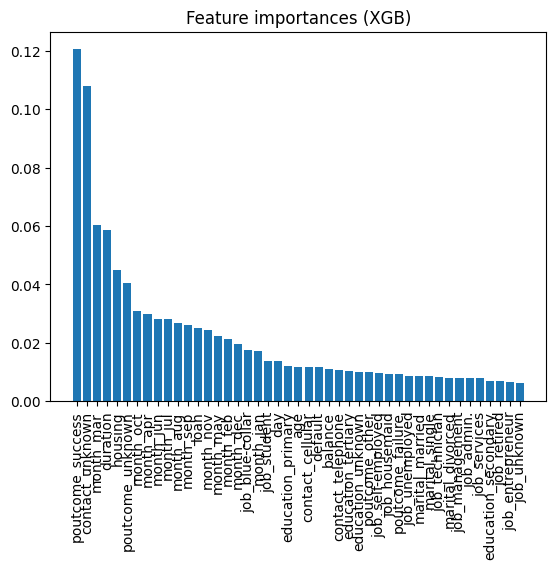

In [16]:
# Getting Feature Importances From the Model
headers = ['name', 'score']
values = sorted(zip(X_train.columns, xgb_model.feature_importances_), key=lambda x: x[1], reverse=True)

xgb_feature_importances = pd.DataFrame(values, columns=headers)

# plot feature importances 
x_pos = np.arange(0, len(xgb_feature_importances))
plt.bar(x_pos, xgb_feature_importances['score'])
plt.xticks(x_pos, xgb_feature_importances['name'])
plt.xticks(rotation=90)
plt.title('Feature importances (XGB)')

Futher Examination 
1. for numeric cols, you put buckets, and check if each bucket increases y variable for each bucket. see if there is a high trend. (from this you can actually find the break-even point who to concentrate on)

2. find appropriate amount of contacts for different segments
